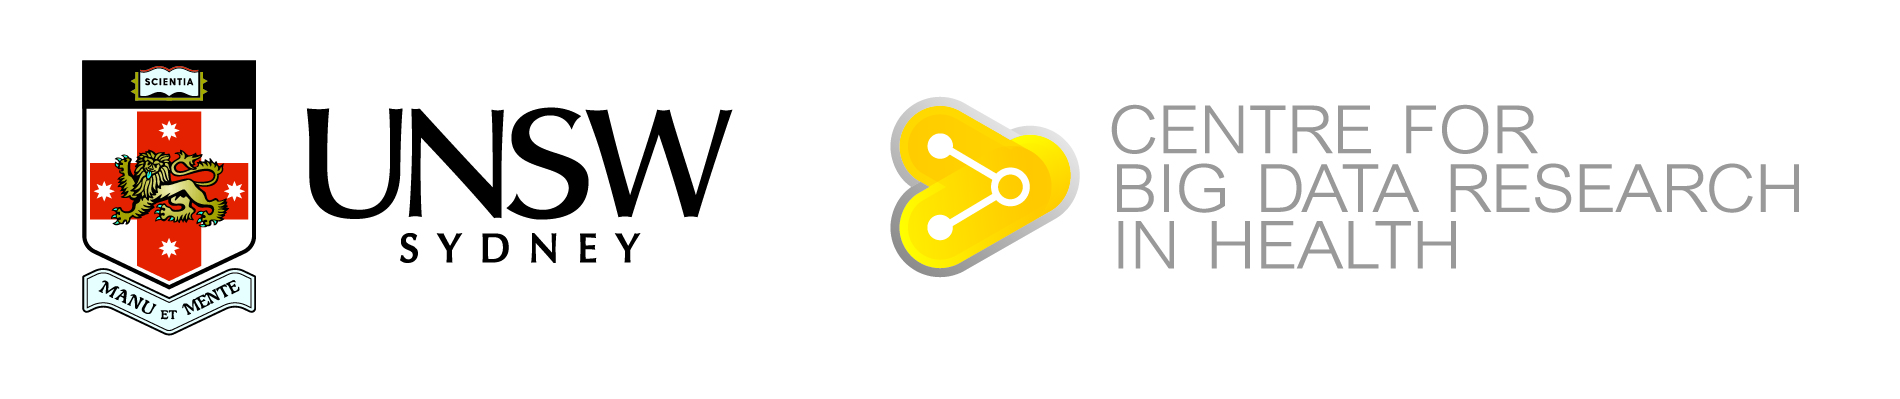

#1. Introduction of Research Background

This notebook explores various predictive machine learning models and feature engineering methodologies in addressing research question 1 : predicting hospital mortality within the first 24 hours of ICU stay, utilizing the open-source MIMIC-III dataset. In the subsequent notebook, a multivariable analysis and cox proportional hazards survival model are developed using a filtered version of the MIMIC-III dataset to address research question 2: investigating whether admission to the ICU during weekends increases the risk of ICU mortality. This statistical model not only forecasts the risk factors associated with ICU mortality but also sheds light on the impact of weekend admissions.

Python scripting is employed to implement four machine learning models: Logistic Regression, GradientBoostingClassifier, Random Forest and AdaBoostClassifier with SMOTE. Among these models, GradientBoostingClassifier and AdaBoostClassifier with SMOTE demonstrate better performance f1, also exhibiting the highest accuracy levels across both training and test sets. R language is scripted when evaluating research question 2. The findings indicate that ICU-admitted patients face a significantly elevated risk of hospital mortality, influenced by various clinical and non-clinical factors. The goal of this research is to furnish healthcare practitioners with a tool to predict the likelihood of a patient's hospital mortality within the initial 24 hours of ICU admission. Additionally, the statistical model aims to aid hospital management in determining the necessity of resource allocation, including nursing staff and physicians, especially during weekends, with the intention of reducing ICU mortality rates.

#2. Data Munging

The data frame can be loaded with the following code:
Exploratory Data Analysis: MIMIC-III database consists of 46,520 unique patients and 61,532 distinct ICU stays. 2.1 Convert date columns

## 2.1 Datetime format conversion
Firstly, after loading all csv files, i replaced commas in the 'diagnosis' column in admission csv with empty spaces and saved modified dataframe to a new csv file. Then date columns “admittime”, “dischtime”, are converted to datetime format to enable efficient analysis of time-related data. Subsequently, “admittime”, “dischtime” are rounded to the nearest hour, facilitating aggregation and comparison of time intervals.

## 2.2 Merge Dataset
The datasets were then merged at different steps. Firstly, the new_admissions dataframe is merged with a subset of columns from the pt_icu_outcome dataframe (“subject_id”, “icustay_id”, “age_years”, “icu_expire_flag”, “ttd_days”) based on the common column subject_id. Only rows with matching subject_id values in both dataframes will be kept in merged_df. Then a ranking of “icustay_num” for each “icustay_id” within each unique subject_id group was calculated. “icustay_id” was displayed in order within each group, using tie breaking method “dense”. Later, the merged_df dataframe is further merged with a subset of columns from the icustays dataframe (“icustay_id”, “los”, “icu_intime”) based on the common column “icustay_id”. All rows in merged_df datadrame will be retained in the resulting dataframe, and missing values will be filled with NaNs for rows where no matches were found. Finally, the resulting dataframe is merged with a subset of columns from the patients dataframe (“subject_id”, “gender”) based on the common column subject_id. Only rows with matching subject_id values in both dataframes are included in the resulting dataframe merged_df.

## 2.3 Create mp_cohort DataFrame
Additionally, a new dataframe, mp_cohort, was created using selected columns from merged_df to capture key attributes ('subject_id', 'hadm_id', 'admittime', 'deathtime', 'admission_type', 'admission_location', 'discharge_location', 'insurance', 'diagnosis', 'hospital_expire_flag', 'has_chartevents_data', 'admittime_hr', 'dischtime_hr', 'icustay_id', 'age_years', 'icustay_num', 'icu_intime', ‘gender, 'ethnicity', 'ttd_days', 'icu_expire_flag'), focusing on a defined timeframe. Missing ICU Length of Stay, ‘icu_los’ values were filled with 0. A new binary column icustay_24hr_or_less was introduced, indicating whether the ICU stay duration was 24 hours or less. Missing values in ‘hospital_expire_flag’, ‘ttd_days’, and ‘icu_expire_flag’ were encoded 0. A new column 'in_hospital_mortality_within24hours_icu' was created to indicate in-hospital mortality during 24 hours ICU stay where 'hospital_expire_flag’ is 1, and 'icustay_24hr_or_less' is 1. The establishment of exclusion criteria involved the creation of several columns: 'exclusion_adult' identified patients below 16 or above 89 years old; 'exclusion_death_before_icu' flagged cases where 'deathtime' occurred before 'icu_intime'; 'exclusion_valid_data' marked entries with missing 'has_chartevents_data', 'admittime_hr', or 'dischtime_hr'; 'exclusion_short_stay_1hr' identified patient stays equal to or less than 1 hour by calculating the difference between discharge and admission times. Furthermore, 'exclusion_organ_donor' indicated instances where the diagnosis included the term 'organ donor'. These criteria were meticulously established to eliminate irrelevant conditions for future analyses. Subsequently, the resulting dataset, named 'cohort', was saved to a CSV file, prepared for machine learning analyses and modeling.

## 2.4 Filter cohort and create study_cohort DataFrame
The study_cohort was created by selecting only those rows where the predefined exclusion criteria was not met. Next, duplicated rows of 'icustay_id' were dropped, so each ICU stay was unique in study_cohort. Additionally, missing values were handled by forward filling to maintain data continuity. In preparation for subsequent machine learning analyses, a LabelEncoder was employed. This encoder was applied to columns 'admission_type', 'admission_location', 'discharge_location', 'insurance', 'gender', and 'ethnicity', effectively transforming categorical variables into numerical representations. The resulting label mappings were stored in a dictionary label_mappings. In study_cohort, there are 50,579 distinct ICU stays, and 36,496 distinct patients. In-hospital mortality ratio is  8.62%, 4358 patients died in hospital, 46,221 were not died using 'hospital_expire_flag' = 1.


## 2.5 New column 'weekend_admission' for question 2
A new column 'weekend_admission' was generated to indicate whether a patient's ICU admission, 'icu_intime' column, fell on a weekend. This binary column takes on values of 1 or 0, with 1 representing an ICU admission during the weekend, and 0 denoting admissions on weekdays. There are 10,893 patients admitted into ICU during the weekend, 39,686 patients otherwise.

## 2.6 Create dataset final_df for question 2
I combined the gcs_hourly and vitals_hourly DataFrames, as well as the labs_hourly DataFrame, by matching 'icustay_id' and 'hr' values with inner joins. Then, I filled missing values in the merged_hourly DataFrame by carrying forward the most recent non-missing value within each column. The resulting summary_df contains data for 42,355 unique 'icustay_id'. Since some values like FiO2 or respiratory rate may be artificial in ICU settings, I excluded these two and computed the max, min, and difference for each clinical measurement column per 'icustay_id'. Next, I merged study_cohort and summary_df based on 'icustay_id' with an outer join. I filled any missing values in the merged DataFrame using the forward fill method and dropped rows with any remaining missing values, as only a small percentage were missing.

# HDAT9100 Q1 Data Munging Code

### Package Loading & Data Munging

Load required libraries prior to analysis.

In [2]:
# @title
# check required libraries are installed if not calling system to install
import sys
import subprocess
import pkg_resources

required = {'numpy', 'pandas', 'plotnine', 'matplotlib', 'seaborn',
            'grid', 'lime', 'shap', 'scikit-learn', 'tensorflow'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    print('Installing: ', missing)
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)
# delete unwanted variables
del required
del installed
del missing


Installing:  {'lime', 'grid', 'shap'}


In [3]:
# @title
#Load library
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.model_selection import train_test_split

In [4]:
# @title
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [5]:
# @title
import sys
print(sys.version)

import numpy as np
import pandas as pd
from IPython.display import display

import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import random
import warnings; warnings.simplefilter('ignore')

3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


In [6]:
# @title
if 'google.colab' in str(get_ipython()):
    from google.colab import drive # import drive from Gogle colab
    root = '/content/drive'        # default location for the drive
    # print(root)                  # print content of ROOT (Optional)
    drive.mount(root)
else:
    print('Not running on CoLab')

Mounted at /content/drive


In [7]:
# @title
from pathlib import Path

if 'google.colab' in str(get_ipython()):
    # EDIT THE PROJECT PATH IF DIFFERENT WITH YOUR ONE
    project_path = Path(root) / 'MyDrive' / 'HDAT9910'

else:
    project_path = Path()


In [8]:
# @title
# access data
import pandas as pd
# Specify the path to your CSV file
icu_outcome_path = Path(root) /'MyDrive'/'HDAT9910'/'mimic_data'/'pt_icu_outcome.csv'
patients_path = Path(root) /'MyDrive'/'HDAT9910'/'mimic_data'/'patients.csv'

# Load CSV data into a DataFrame
patients = pd.read_csv(patients_path)
icu_outcome = pd.read_csv(icu_outcome_path)
print('Number of distinct patients in orginal database: ', patients.subject_id.unique().shape[0])
print('Number of distinct ICU stays in orginal database: ', icu_outcome.icustay_id.unique().shape[0])


Number of distinct patients in orginal database:  46520
Number of distinct ICU stays in orginal database:  61532


In [9]:
# @title
# Load the ADMISSIONS.csv file into a DataFrame
admissions = pd.read_csv(Path(root) /'MyDrive'/'HDAT9910'/'mimic_data'/'admissions.csv')

# Replace commas in the 'diagnosis' column with empty spaces
admissions['diagnosis'] = admissions['diagnosis'].str.replace(',', ' ')

# Save the modified DataFrame to a new CSV file
admissions.to_csv(Path(root) /'MyDrive'/'HDAT9910'/'mimic_data'/'new_ADMISSIONS.csv', index=False)

# Load the new_ADMISSIONS.csv,pt_icu_outcome.csv,transfers.csv file into a DataFrame
new_admissions = pd.read_csv(Path(root) /'MyDrive'/'HDAT9910'/'mimic_data'/'new_ADMISSIONS.csv')

pt_icu_outcome= pd.read_csv(Path(root) /'MyDrive'/'HDAT9910'/'mimic_data'/'pt_icu_outcome.csv')

transfers= pd.read_csv(Path(root) /'MyDrive'/'HDAT9910'/'mimic_data'/'transfers.csv')
icustays = pd.read_csv(Path(root) /'MyDrive'/'HDAT9910'/'mimic_data'/'icustays.csv')
patients = pd.read_csv(Path(root) /'MyDrive'/'HDAT9910'/'mimic_data'/'patients.csv')
vitals_hourly = pd.read_csv(Path(root) /'MyDrive'/'HDAT9910'/'mimic_data'/'vitals_hourly.csv')
labs_hourly = pd.read_csv(Path(root) /'MyDrive'/'HDAT9910'/'mimic_data'/'labs_hourly.csv')
gcs_hourly = pd.read_csv(Path(root) /'MyDrive'/'HDAT9910'/'mimic_data'/'gcs_hourly.csv')
icd9_diag = pd.read_csv(Path(root) /'MyDrive'/'HDAT9910'/'mimic_data'/'icd9_diag.csv')

In [10]:
from pathlib import Path
import pandas as pd
import numpy as np

# Preprocess and Clean Data
new_admissions['admittime'] = pd.to_datetime(new_admissions['admittime'])
new_admissions['dischtime'] = pd.to_datetime(new_admissions['dischtime'])

new_admissions['admittime_hr'] = new_admissions['admittime'].dt.ceil('H')
new_admissions['dischtime_hr'] = new_admissions['dischtime'].dt.ceil('H')
new_admissions['deathtime'] = pd.to_datetime(new_admissions['deathtime'])
icustays['icu_intime'] = pd.to_datetime(icustays['intime'])

# Merge Datasets
# The patients time to death from ICU entry in days is the ttd column, use later for Cox Proportional Hazards Survival Model
merged_df = new_admissions.merge(pt_icu_outcome[['subject_id', 'icustay_id', 'age_years','icu_expire_flag','ttd_days']], on='subject_id', how='inner')
merged_df['icustay_num'] = merged_df.groupby('subject_id')['icustay_id'].rank(method='dense')
merged_df = merged_df.merge(icustays[['icustay_id', 'los','icu_intime']], on='icustay_id', how='left')
# Merge patients DataFrame to include 'gender' column
merged_df = merged_df.merge(patients[['subject_id', 'gender']], on='subject_id', how='inner')


# Create mp_cohort dataframe
mp_cohort = merged_df[[
    'subject_id', 'hadm_id', 'admittime', 'deathtime', 'admission_type', 'admission_location', 'discharge_location', 'insurance',
    'diagnosis', 'hospital_expire_flag', 'has_chartevents_data', 'admittime_hr', 'dischtime_hr', 'icustay_id', 'age_years', 'icustay_num',
    'icu_intime', 'gender', 'ethnicity','ttd_days','icu_expire_flag'
]]

# Use 'age_years' as age
# mp_cohort['age'] = mp_cohort['age_years']

# Fix ICU LOS calculation and handle missing values, assuming 0 for missing values
mp_cohort['icu_los'] = icustays['los']
mp_cohort['icu_los'].fillna(0, inplace=True)

# Create a new column for ICU stays less than or equal to 24 hours
mp_cohort['icustay_24hr_or_less'] = (mp_cohort['icu_los'] <= 1).astype(int)

# Handle missing values in 'hospital_expire_flag','ttd_days'，'icu_expire_flag'
mp_cohort['hospital_expire_flag'].fillna(0, inplace=True)  # Assuming 0 for missing values (survival)
mp_cohort['ttd_days'].fillna(0, inplace=True)
mp_cohort['icu_expire_flag'].fillna(0, inplace=True)
# Create a new column to indicate in-hospital mortality during 24 hours ICU stay
mp_cohort['in_hospital_mortality_within24hours_icu'] = ((mp_cohort['hospital_expire_flag'] == 1) & (mp_cohort['icustay_24hr_or_less'] == 1)).astype(int)

# Simplify exclusion criteria checks
mp_cohort['exclusion_adult'] = ((mp_cohort['age_years'] <= 16) | (mp_cohort['age_years'] >= 89)).astype(int)
mp_cohort['exclusion_death_before_icu'] = (mp_cohort['deathtime'] <= mp_cohort['icu_intime']).astype(int)
mp_cohort['exclusion_valid_data'] = mp_cohort[['has_chartevents_data', 'admittime_hr', 'dischtime_hr']].isnull().any(axis=1).astype(int)
mp_cohort['exclusion_short_stay_1hr'] = ((mp_cohort['dischtime_hr'] - mp_cohort['admittime_hr']).dt.total_seconds() <= 1*3600).astype(int)
mp_cohort['exclusion_organ_donor'] = (((mp_cohort['diagnosis'].str.lower().str.contains('organ donor')) & mp_cohort['deathtime'].notnull()) | ((mp_cohort['diagnosis'].str.lower().str.contains('donor account')) & mp_cohort['deathtime'].notnull())).astype(int)
exclusion_columns = ['exclusion_adult','exclusion_death_before_icu','exclusion_valid_data', 'exclusion_short_stay_1hr', 'exclusion_organ_donor']
mp_cohort['excluded'] = mp_cohort[exclusion_columns].max(axis=1)

# Order the columns and drop duplicates
final_columns = [
    'subject_id', 'hadm_id', 'icustay_id', 'admittime_hr', 'dischtime_hr', 'icustay_24hr_or_less','in_hospital_mortality_within24hours_icu',
    'age_years', 'gender', 'ethnicity', 'admission_type', 'icustay_num', 'icu_intime','ttd_days','icu_expire_flag',
    'icu_los', 'deadthtime_check', 'exclusion_adult', 'exclusion_death_before_icu','exclusion_valid_data',
    'exclusion_short_stay_1hr', 'exclusion_organ_donor', 'excluded'
]

# Save the mp_cohort DataFrame to a new CSV file

mp_cohort.to_csv(Path(root) / 'MyDrive' / 'HDAT9910' / 'mimic_data' / 'mp_cohort.csv', index=False)

# Read the cohort CSV file
cohort = pd.read_csv(Path(root) / 'MyDrive' / 'HDAT9910' / 'mimic_data' / 'mp_cohort.csv')

In [11]:
from sklearn.preprocessing import LabelEncoder

#selecting only the rows where the 'excluded' column does not meet the exclusion criteria.
study_cohort = cohort[cohort.excluded==0]

# Drop duplicates based on 'icustay_id' to get unique ICU stays
study_cohort.drop_duplicates(subset='icustay_id', inplace=True)
# Fill NaN values with forward filling
study_cohort.fillna(method='ffill', inplace=True)
#study_cohort.fillna(value=study_cohort.median(), inplace=True)

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# List of columns to encode
columns_to_encode = ['admission_type','admission_location', 'discharge_location', 'insurance','gender','ethnicity']

# Dictionary to store mappings
label_mappings = {}

# Loop through each column and transform
for col in columns_to_encode:
    study_cohort[col] = label_encoder.fit_transform(study_cohort[col])
    label_mappings[col] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Print the mappings
for col, mapping in label_mappings.items():
    print("Mapping for column '{}':".format(col))
    for key, value in mapping.items():
        print("   {} : {}".format(key, value))

print('Number of distinct ICU stays: ', study_cohort.icustay_id.unique().shape[0])
print('Number of distinct patients: ', study_cohort.subject_id.unique().shape[0])

print(study_cohort.shape)
study_cohort.head()

Mapping for column 'admission_type':
   ELECTIVE : 0
   EMERGENCY : 1
   URGENT : 2
Mapping for column 'admission_location':
   ** INFO NOT AVAILABLE ** : 0
   CLINIC REFERRAL/PREMATURE : 1
   EMERGENCY ROOM ADMIT : 2
   HMO REFERRAL/SICK : 3
   PHYS REFERRAL/NORMAL DELI : 4
   TRANSFER FROM HOSP/EXTRAM : 5
   TRANSFER FROM OTHER HEALT : 6
   TRANSFER FROM SKILLED NUR : 7
   TRSF WITHIN THIS FACILITY : 8
Mapping for column 'discharge_location':
   DEAD/EXPIRED : 0
   DISC-TRAN CANCER/CHLDRN H : 1
   DISC-TRAN TO FEDERAL HC : 2
   DISCH-TRAN TO PSYCH HOSP : 3
   HOME : 4
   HOME HEALTH CARE : 5
   HOME WITH HOME IV PROVIDR : 6
   HOSPICE-HOME : 7
   HOSPICE-MEDICAL FACILITY : 8
   ICF : 9
   LEFT AGAINST MEDICAL ADVI : 10
   LONG TERM CARE HOSPITAL : 11
   OTHER FACILITY : 12
   REHAB/DISTINCT PART HOSP : 13
   SHORT TERM HOSPITAL : 14
   SNF : 15
   SNF-MEDICAID ONLY CERTIF : 16
Mapping for column 'insurance':
   Government : 0
   Medicaid : 1
   Medicare : 2
   Private : 3
   Self Pay

,subject_id,hadm_id,admittime,deathtime,admission_type,admission_location,discharge_location,insurance,diagnosis,hospital_expire_flag,...,icu_expire_flag,icu_los,icustay_24hr_or_less,in_hospital_mortality_within24hours_icu,exclusion_adult,exclusion_death_before_icu,exclusion_valid_data,exclusion_short_stay_1hr,exclusion_organ_donor,excluded
0,22,165315,2196-04-09 12:26:00,NaN,1,2,1,3,BENZODIAZEPINE OVERDOSE,0,...,0,3.2490,0,0,0,0,0,0,0,0
1,23,152223,2153-09-03 07:15:00,NaN,0,4,5,2,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,...,0,3.2788,0,0,0,0,0,0,0,0
2,23,152223,2153-09-03 07:15:00,NaN,0,4,5,2,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,...,0,2.8939,0,0,0,0,0,0,0,0
5,24,161859,2139-06-06 16:14:00,NaN,1,5,4,3,INTERIOR MYOCARDIAL INFARCTION,0,...,0,1.4862,0,0,0,0,0,0,0,0
6,25,129635,2160-11-02 02:06:00,NaN,1,2,4,3,ACUTE CORONARY SYNDROME,0,...,0,8.8143,0,0,0,0,0,0,0,0


In [12]:
mortality_dist = study_cohort.hospital_expire_flag.value_counts()
print('In-hospital mortality ratio:' , mortality_dist[1]/mortality_dist.sum()* 100) # Multiply by 100 for percentage
print('In-hospital mortality distribution:\n', mortality_dist)

#print('Num of in-hospital mortality: ', study_cohort[study_cohort.hospital_expire_flag==1].shape[0])

In-hospital mortality ratio: 8.616224124636707
In-hospital mortality distribution:
 hospital_expire_flag
0    46221
1     4358
Name: count, dtype: int64


In [13]:
# Convert icu_intime to datetime if not already in datetime format
study_cohort['icu_intime'] = pd.to_datetime(study_cohort['icu_intime'])

# Create a new column for weekend admission
study_cohort['weekend_admission'] = (study_cohort['icu_intime'].dt.dayofweek >= 5).astype(int)
pd.set_option('display.max_columns', None) #Set display options to show all columns
study_cohort.head(10)

,subject_id,hadm_id,admittime,deathtime,admission_type,admission_location,discharge_location,insurance,diagnosis,hospital_expire_flag,has_chartevents_data,admittime_hr,dischtime_hr,icustay_id,age_years,icustay_num,icu_intime,gender,ethnicity,ttd_days,icu_expire_flag,icu_los,icustay_24hr_or_less,in_hospital_mortality_within24hours_icu,exclusion_adult,exclusion_death_before_icu,exclusion_valid_data,exclusion_short_stay_1hr,exclusion_organ_donor,excluded,weekend_admission
0,22,165315,2196-04-09 12:26:00,NaN,1,2,1,3,BENZODIAZEPINE OVERDOSE,0,1,2196-04-09 13:00:00,2196-04-10 16:00:00,204798,64.0,1.0,2196-04-09 12:27:00,0,36,0.0,0,3.2490,0,0,0,0,0,0,0,0,1
1,23,152223,2153-09-03 07:15:00,NaN,0,4,5,2,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,2153-09-03 08:00:00,2153-09-08 20:00:00,227807,71.0,1.0,2153-09-03 09:38:55,1,36,0.0,0,3.2788,0,0,0,0,0,0,0,0,0
2,23,152223,2153-09-03 07:15:00,NaN,0,4,5,2,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,2153-09-03 08:00:00,2153-09-08 20:00:00,234044,75.0,2.0,2157-10-21 11:40:38,1,36,0.0,0,2.8939,0,0,0,0,0,0,0,0,0
5,24,161859,2139-06-06 16:14:00,NaN,1,5,4,3,INTERIOR MYOCARDIAL INFARCTION,0,1,2139-06-06 17:00:00,2139-06-09 13:00:00,262236,39.0,1.0,2139-06-06 16:15:36,1,36,0.0,0,1.4862,0,0,0,0,0,0,0,0,1
6,25,129635,2160-11-02 02:06:00,NaN,1,2,4,3,ACUTE CORONARY SYNDROME,0,1,2160-11-02 03:00:00,2160-11-05 15:00:00,203487,58.0,1.0,2160-11-02 03:16:23,1,36,0.0,0,8.8143,0,0,0,0,0,0,0,0,1
7,26,197661,2126-05-06 15:16:00,NaN,1,5,4,2,V-TACH,0,1,2126-05-06 16:00:00,2126-05-13 15:00:00,244882,72.0,1.0,2126-05-07 09:52:30,1,35,658.0,0,7.1314,0,0,0,0,0,0,0,0,0
9,28,162569,2177-09-01 07:15:00,NaN,0,4,5,2,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,2177-09-01 08:00:00,2177-09-06 16:00:00,225559,74.0,1.0,2177-09-01 09:32:26,1,36,0.0,0,0.7313,1,0,0,0,0,0,0,0,0
11,31,128652,2108-08-22 23:27:00,2108-08-30 15:00:00,1,5,0,2,STATUS EPILEPTICUS,1,1,2108-08-23 00:00:00,2108-08-30 15:00:00,254478,72.0,1.0,2108-08-22 23:28:42,1,36,7.0,0,13.9504,0,0,0,0,0,0,0,0,0
12,32,175413,2170-04-04 08:00:00,2108-08-30 15:00:00,0,4,4,1,TRACHEAL STENOSIS/SDA,0,1,2170-04-04 08:00:00,2170-04-23 13:00:00,295037,45.0,1.0,2170-04-04 18:46:00,1,36,0.0,0,7.7389,0,0,0,0,0,0,0,0,0
13,33,176176,2116-12-23 22:30:00,2108-08-30 15:00:00,1,2,4,2,SEPSIS;TELEMETRY,0,1,2116-12-23 23:00:00,2116-12-27 13:00:00,296681,82.0,1.0,2116-12-23 22:31:53,1,35,0.0,0,0.8519,1,0,0,0,0,0,0,0,0


In [14]:
# Calculate mean mortality rate by weekend admission
mortality_counts = study_cohort.groupby('weekend_admission')['icu_expire_flag'].value_counts().unstack()
#total_counts = study_cohort['weekend_admission'].value_counts()
mortality_counts
#total_counts



icu_expire_flag,0,1
weekend_admission,,
0,39484,202
1,10833,60


In [15]:
study_cohort.columns

Index(['subject_id', 'hadm_id', 'admittime', 'deathtime', 'admission_type',
       'admission_location', 'discharge_location', 'insurance', 'diagnosis',
       'hospital_expire_flag', 'has_chartevents_data', 'admittime_hr',
       'dischtime_hr', 'icustay_id', 'age_years', 'icustay_num', 'icu_intime',
       'gender', 'ethnicity', 'ttd_days', 'icu_expire_flag', 'icu_los',
       'icustay_24hr_or_less', 'in_hospital_mortality_within24hours_icu',
       'exclusion_adult', 'exclusion_death_before_icu', 'exclusion_valid_data',
       'exclusion_short_stay_1hr', 'exclusion_organ_donor', 'excluded',
       'weekend_admission'],
      dtype='object')

#3. Analytics Conducted

As in_hospital_mortality_within24hours_icu column from study_cohort is already in binary values, representing 0 for "no" and 1 for "yes". I proceeded to split the dataset into two DataFrames: the features, denoted as X (including all variables except for 'subject_id','hadm_id','icustay_id','admittime','diagnosis','hospital_expire_flag','dischtime_hr','in_hospital_mortality_within24hours_icu','icu_intime','admittime_hr','deathtime','icu_los','icustay_24hr_or_less','ttd_days','icu_expire_flag','exclusion_adult','exclusion_death_before_icu','exclusion_valid_data','exclusion_short_stay_1hr','exclusion_organ_donor', 'excluded' columns), and the target is denoted as y (containing only the in_hospital_mortality_within24hours_icu column). There are 47771 patients in class 0, 2808 in class 1, suggesting imbalance of dataset. Then I divided the data into 80% for training and 20% for testing, using stratify=y to preserve the class ratio on both sets, a random seed of 30 was employed to ensure the reproducibility of the data split. The training set was subsequently employed for model training, while the test set served to evaluate the model's generalization performance on unseen data.


In [16]:
# @title
X = study_cohort.drop(['subject_id', 'hadm_id', 'icustay_id', 'admittime','diagnosis','hospital_expire_flag','dischtime_hr','in_hospital_mortality_within24hours_icu',
'icu_intime','admittime_hr','deathtime','icu_los', 'icustay_24hr_or_less','ttd_days','icu_expire_flag',
       'exclusion_adult', 'exclusion_death_before_icu', 'exclusion_valid_data',
       'exclusion_short_stay_1hr', 'exclusion_organ_donor', 'excluded'], axis=1)    # features

#define y as the output of our algorithm. YES-mortality within 24 hours ICU stay, NO-no mortality within 24 hours ICU.

y=study_cohort["in_hospital_mortality_within24hours_icu"].values

# Print the number of rows and columns using 'DataFrame.shape':
print("Number of rows and columns: ",X.shape)

# Print the columns/features names of our dataset using 'DataFrame.columns':
print("Features of hospital data:", X.columns)

# Print dtypes using 'DataFrame.shape':
print("Data types are: ", X.dtypes)

Number of rows and columns:  (50579, 10)
Features of hospital data: Index(['admission_type', 'admission_location', 'discharge_location',
       'insurance', 'has_chartevents_data', 'age_years', 'icustay_num',
       'gender', 'ethnicity', 'weekend_admission'],
      dtype='object')
Data types are:  admission_type            int64
admission_location        int64
discharge_location        int64
insurance                 int64
has_chartevents_data      int64
age_years               float64
icustay_num             float64
gender                    int64
ethnicity                 int64
weekend_admission         int64
dtype: object


In [17]:
# @title
import numpy as np

# Count the occurrences of each class
class_counts = np.bincount(y)

# Print the number of samples for each class
print("Number of samples for class 0 (No mortality):", class_counts[0])
print("Number of samples for class 1 (Mortality):", class_counts[1])


Number of samples for class 0 (No mortality): 47771
Number of samples for class 1 (Mortality): 2808


In [18]:
# @title
#Divide the data into 80% for training and 20% for testing, using a random seed of 30.
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=30, test_size = 0.20)

In [19]:
# @title
import numpy as np

# Count the occurrences of each class in y_train
class_counts_train = np.bincount(y_train)

# Print the number of samples for each class in y_train
print("Number of samples for class 0 (No mortality) in y_train:", class_counts_train[0])
print("Number of samples for class 1 (Mortality) in y_train:", class_counts_train[1])


Number of samples for class 0 (No mortality) in y_train: 38217
Number of samples for class 1 (Mortality) in y_train: 2246


## 3.1 Logistic Regression
The features in training set was standardised using StandardScaler. For logistic regression model, solver='saga' and l1_ratio=0.5 were used to balance L1 and L2 regularisations. The solver=saga supported these fast processing of large datasets.
Class weights were applied to handle the imbalanced data (38217 patients in class 0 in y_train, and 2246 patients in class 1) by assigning higher weights to the minority class for accurate predictions. Grid search was used to find the best hyperparameters. The printed results reveal the best hyperparameters discovered by the search and the corresponding F1 score 0.78. Confusion matrices were computated for each set to further assess the predictions. Accuracy score of test and train dataset are 0.972 and 0.969 respectively.

In [20]:
# @title
import random
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Set the seed for the random module
random.seed(42)

# Scaler/Standardization
scaler = StandardScaler()

# Classification Model
class_weight_dict = [{1: 0.8, 0: 0.2}, {1: 0.7, 0: 0.3}]

# Define the hyperparameter grid for the GridSearchCV
param_grid = {
    'Estimator__C': [10, 100],
    'Estimator__class_weight': class_weight_dict,
    'Estimator__penalty': ['elasticnet', None]
}

log_reg = LogisticRegression(solver='saga', l1_ratio=0.5)

# Pipeline:
pipe = Pipeline([
    ('Transform', scaler),
    ('Estimator', log_reg)
])

# Define the GridSearchCV with f1 as the scoring metric and 3-fold cross-validation
grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=3, scoring='f1', n_jobs=-1)

# Ensure X_train and y_train are defined
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding f1 score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-validation Score:", grid_search.best_score_)


Best Hyperparameters: {'Estimator__C': 10, 'Estimator__class_weight': {1: 0.7, 0: 0.3}, 'Estimator__penalty': None}
Best Cross-validation Score: 0.781419575585705


In [21]:
# @title
def plot_confusion_matrix(confusion_matrix):
  # visualise the confusion matrix
  labels = ['No', 'Yes']
  ax = plt.subplot()
  sns.heatmap(confusion_matrix, annot = True, fmt = '.0f', ax = ax, cmap = 'viridis')

  # labels, titles and ticks
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix')
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

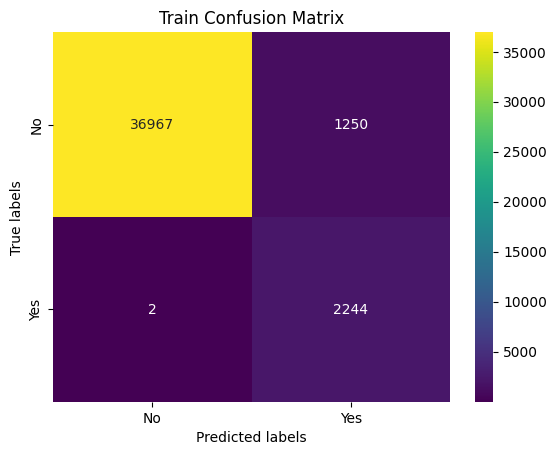

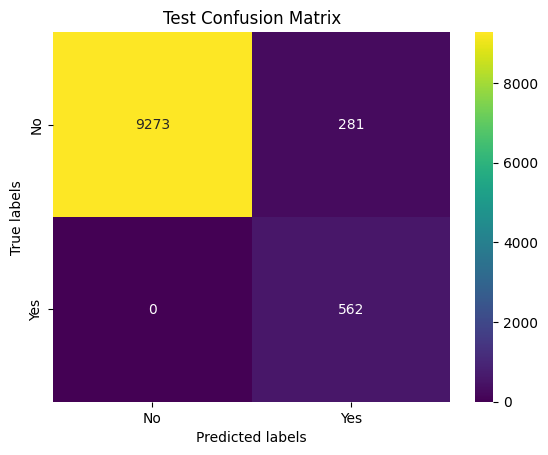

Accurary score of test dataset: 0.9722222222222222
Accurary score of train dataset: 0.9690581518918518


In [22]:
# @title
# Make predictions on the training set using the best estimator
y_train_pred = grid_search.predict(X_train)

# Make predictions on the test set using the best estimator
y_test_pred = grid_search.predict(X_test)

# Calculate the confusion matrices
train_confusion_matrix = confusion_matrix(y_train, y_train_pred)
test_confusion_matrix = confusion_matrix(y_test, y_test_pred)


#plt.figure(figsize=(12, 6)), don't need these two
#plt.subplot(1, 2, 1)，add title
plot_confusion_matrix(train_confusion_matrix)
plt.title("Train Confusion Matrix")
plt.show()
#plt.subplot(1, 2, 2), add title
plot_confusion_matrix(test_confusion_matrix)
plt.title("Test Confusion Matrix")
plt.show()


print("Accurary score of test dataset:", accuracy_score(y_test,y_test_pred))
print("Accurary score of train dataset:", accuracy_score(y_train,y_train_pred))


# GradientBoostingClassifier Model

## 3.2 GradientBoostingClassifier Model
I instantiated GradientBoostingClassifier Model with parameters specifying 40 boosting stages and a fixed random seed 42 for reproducibility. This ensemble technique can handle complex dataset well, and is trained on X_train and y_train, followed by making predictions on test set using gbm_clf.predict(X_test). The accuracy of the model on the test set is 0.973, and overall weighted average F1-score is 0.98. Confusion matrice for each set was computated to further assess the predictions using plot_confusion_matrix function. The classification report was extracted from the confusion matrix for each training and test set.

Accuracy Score on Test Set: 0.9730130486358244
The classification report for test set: 
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      9554
           1       0.68      0.96      0.80       562

    accuracy                           0.97     10116
   macro avg       0.84      0.97      0.89     10116
weighted avg       0.98      0.97      0.98     10116



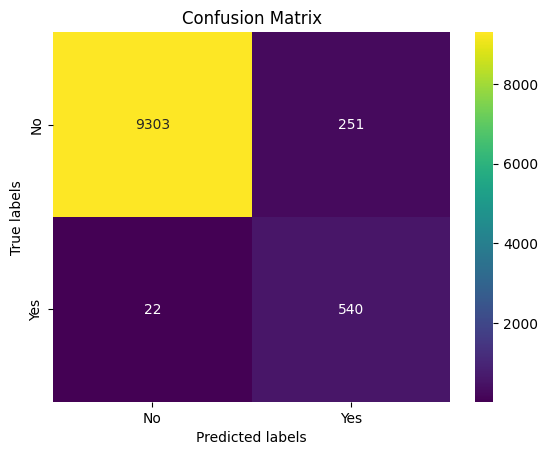

In [23]:
# @title
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Define the GradientBoostingClassifier with adjusted class weights
gbm_clf = GradientBoostingClassifier(
    n_estimators=40,
    random_state=42
)

# Train the GradientBoostingClassifier model
gbm_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred_gb = gbm_clf.predict(X_test)

# Calculate the accuracy on the test set
accuracy = accuracy_score(y_test, y_pred_gb)
print("Accuracy Score on Test Set:", accuracy)

# Compute and print the classification report for test set
print("The classification report for test set: ")
print(classification_report(y_test, y_pred_gb))

# Calculate and plot the confusion matrix for test set
plot_confusion_matrix(confusion_matrix(y_test, y_pred_gb))

## 3.3 Random Forest

A random state of 30 is used to ensure reproducibility during data splitting. A dictionary grid was then created to facilitate grid search, allowing us to explore various hyperparameter combinations. To address the imbalanced nature of the data, class weights were defined, assigning higher weights to the minority class and mitigating biases toward the majority class. The grid search algorithm iteratively searched for the best hyperparameters, optimizing the model's performance. Upon fitting the model to the training data, we applied the ravel() function to y_train. This conversion from a 2D to a 1D array helps prevent potential errors or inconsistencies during model training. The best hyperparameters were displayed, and the resulting F1 score is 0.75, reflecting the model's performance.



In [24]:
from sklearn.ensemble import RandomForestClassifier

# Initialise the hyperparameters
n_estimators = [10, 50]                                         # fixed hyperparameters
class_weight = [{0: 1, 1: 1}]               # fixed hyperparameters
max_features = [0, 10]                                           # non-fixed hyperparameters
min_samples_split = [20, 25]                                      # non-fixed hyperparameters

# Initialise the model and set parameters not specified to their defaults
rf = RandomForestClassifier(random_state = 30)

# Create a dictionary grid for grid search
param_grid2 = {'n_estimators': n_estimators,'class_weight': class_weight,'max_features': max_features,'min_samples_split': min_samples_split}

# Fit grid search to the train data with 3-fold cross-validation and F1 score as the scoring metric
grid_search2 = GridSearchCV(estimator = rf, param_grid = param_grid2, cv = 3, scoring = 'f1', n_jobs = -1).fit(X_train, y_train.ravel())

# Print the best hyperparameters and the corresponding F1 score
print("Best parameters: {}".format(grid_search2.best_params_))
print("Best cross-validation average f1 score: {:.2f}".format(grid_search2.best_score_))

Best parameters: {'class_weight': {0: 1, 1: 1}, 'max_features': 10, 'min_samples_split': 25, 'n_estimators': 50}
Best cross-validation average f1 score: 0.75


The classification report for training set: 
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     38217
           1       0.77      0.89      0.83      2246

    accuracy                           0.98     40463
   macro avg       0.88      0.94      0.91     40463
weighted avg       0.98      0.98      0.98     40463

The classification report for test set: 
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      9554
           1       0.70      0.78      0.74       562

    accuracy                           0.97     10116
   macro avg       0.84      0.88      0.86     10116
weighted avg       0.97      0.97      0.97     10116



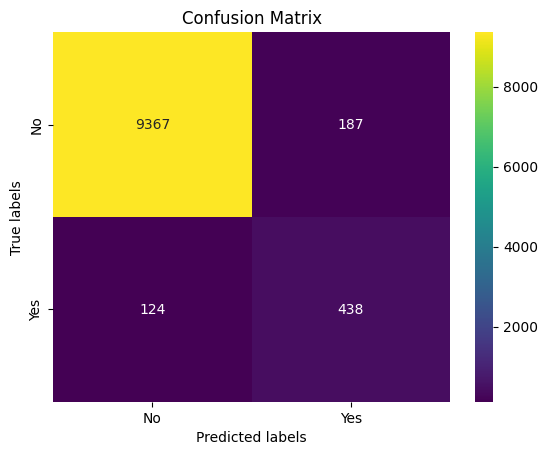

In [25]:
# Define the best model obtained from the grid search
best_model2 = grid_search2.best_estimator_

# Make predictions on the training set using the best model
y_train_pred2 = best_model2.predict(X_train)

# Make predictions on the test set using the best model
y_test_pred2 = best_model2.predict(X_test)

# Compute and print the classification report for training set
print("The classification report for training set: ")
print(classification_report(y_train, y_train_pred2))

# Calculate and plot the confusion matrices for training set
plot_confusion_matrix(confusion_matrix(y_train, y_train_pred2))

# Compute and print the classification report for test set
print("The classification report for test set: ")
print(classification_report(y_test, y_test_pred2))

# Calculate and plot the confusion matrices for test set
plot_confusion_matrix(confusion_matrix(y_test, y_test_pred2))



## 3.4 AdaBoostClassifier with SMOTE
SMOTE was utilized to oversample the minority class in the training data. This approach improves the performance on imbalanced data by generating synthetic samples of the minority class 1 and training a boosting ensemble model on the balanced dataset. The trained AdaBoostClassifier is used to make predictions on the unseen test set (X_test). The accuracy is 0.97, with the weighted average f1-score from classification report is also 0.97.

The feature importances below is derived from the AdaBoostClassifier, indicating that first 3 most important variables of affecting hospital mortality in first 24 hours icu stays are icustay_num, ethnicity, age_years, admission_location and insurance. Admission type and weekend admission doesn't have high influence on the outcome.

Accuracy Score on Test Set: 0.9717279557137208
The classification report for test set: 
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      9554
           1       0.67      0.99      0.80       562

    accuracy                           0.97     10116
   macro avg       0.83      0.98      0.89     10116
weighted avg       0.98      0.97      0.97     10116



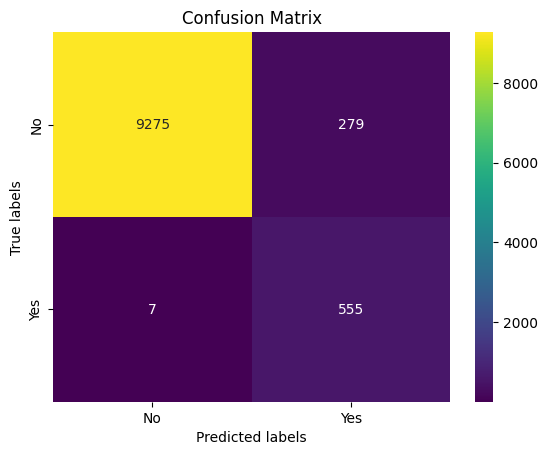

In [26]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Create the SMOTE object
smote = SMOTE(random_state=42)

# Oversample the minority class only on the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Define the AdaBoostClassifier with adjusted class weights
class_weight = {0: 1, 1: 1}
adaboost_clf = AdaBoostClassifier(
    n_estimators=200,
    random_state=42
)

# Train the AdaBoostClassifier model on the SMOTE training data
adaboost_clf.fit(X_train_smote, y_train_smote)

# Make predictions on the test set
y_pred_smote = adaboost_clf.predict(X_test)

# Calculate the accuracy on the test set
accuracy = accuracy_score(y_test, y_pred_smote)
print("Accuracy Score on Test Set:", accuracy)

# Compute and print the classification report for test set
print("The classification report for test set: ")
print(classification_report(y_test, y_pred_smote))

# Calculate and plot the confusion matrix for test set
plot_confusion_matrix(confusion_matrix(y_test, y_pred_smote))

                Feature  Importance
6           icustay_num       0.340
8             ethnicity       0.295
5             age_years       0.285
1    admission_location       0.025
3             insurance       0.020
0        admission_type       0.010
9     weekend_admission       0.010
2    discharge_location       0.005
4  has_chartevents_data       0.005
7                gender       0.005


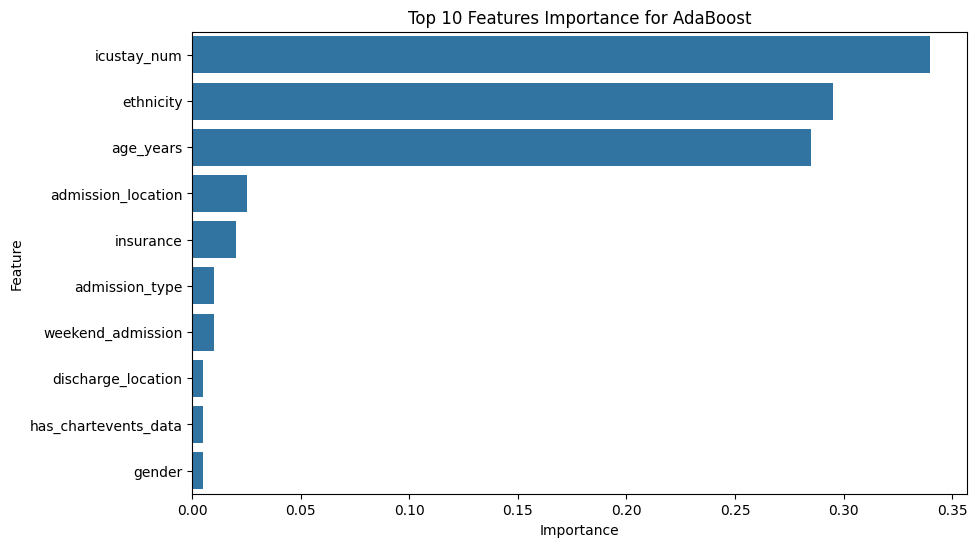

In [27]:
# @title
# Get feature importances
feature_importances = adaboost_clf.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print or visualize the feature importances
print(feature_importance_df)

# Plotting the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Features Importance for AdaBoost')
plt.show()



# 4. Conclusion for Research Question 1

Both GradientBoostingClassifier and AdaBoostClassifier with SMOTE demonstrate good performance across various metrics such as accuracy, precision, recall, and F1-score when predicting hospital mortality within the initial 24 hours of ICU admission. However, the key focus of the research is to correctly classify patients at high risk of mortality. Thus we need to focus on precision and recall for the minority class as well for the reliability and integrity of the predictive model.

Based on the classification report findings, the GradientBoostingClassifier model outperforms other three model in predicting class 1, representing patients with hospital mortality within the first 24 hours of ICU stay. This model exhibits a precision of 0.7, indicating its ability to correctly identify class 1 instances 70% of the time, along with the highest recall of 0.96, signifying its capacity to accurately identify 96% of actual instances within class 1. Consequently, it achieves the highest F1-score of 0.8. The AdaBoostClassifier with SMOTE also demonstrates favorable recall (0.99) and precision (0.67), resulting in an F1-score of 0.8 for predicting mortality in the test set.

Misidentifying patients at high mortality risk within the initial 24 hours of ICU admission can have severe implications, including adverse health outcomes, inefficient resource allocation, compromised patient safety, and negative repercussions on the hospital's reputation. These consequences may lead to financial penalties or reduced reimbursements from government agencies.

## Create final_df for question 2 using gcs_hourly, vitals_hourly,labs_hourly and study_cohort **

### Outcome Variables
<li> <em>hospital_expire_flag:</em>   0:survivor/1:died in-hospital **This is the outcome variable for Question 1: ML Models** </li>
<li> <em>icu_expire_flag:</em>        0:survivor/1:died in icu  **This is the censoring variable for Question 2: Survival Analysis** </li>
<li> <em>ddt_days:</em>                Length of survival (in days) **This is the survival time variable for Question 2: Survival Analysis** </li>


In [28]:
import pandas as pd
# Merge gcs_hourly and vitals_hourly on 'icustay_id' and 'hr'
merged_hourly = pd.merge(gcs_hourly, vitals_hourly, on=['icustay_id', 'hr'], how='inner')

# Merge merged_df with labs_hourly on 'icustay_id' and 'hr'
merged_hourly = pd.merge(merged_hourly, labs_hourly, on=['icustay_id', 'hr'], how='inner')

# Handle missing values with forward fill missing values
merged_hourly = merged_hourly.ffill()

# Display the first few rows of the merged DataFrame
print(merged_hourly.head(10))

   icustay_id   hr  gcs  gcseyes  gcsmotor  gcsverbal  endotrachflag  \
0      200001   16   14      3.0       6.0        5.0              0   
1      200003    5   15      4.0       6.0        5.0              0   
2      200003   22    7      2.0       4.0        1.0              1   
3      200003   35    8      2.0       5.0        1.0              1   
4      200003   63   10      3.0       6.0        1.0              1   
5      200003   73    9      3.0       5.0        1.0              1   
6      200003  113   15      4.0       6.0        5.0              0   
7      200003  119   15      4.0       6.0        5.0              0   
8      200006    7   15      4.0       6.0        5.0              0   
9      200009    7    3      1.0       1.0        1.0              1   

         spo2  fio2  temperature  resprate  heartrate       sysbp     diasbp  \
0  100.000000   NaN    37.444444      17.0     111.00   89.000000  53.000000   
1   97.000000   NaN    37.444444      31.0     

In [29]:
# Check the number of unique 'icustay_id'
unique_icustay_id_count = merged_hourly['icustay_id'].nunique()
print("Number of unique 'icustay_id':", unique_icustay_id_count)
print(merged_hourly.columns)

Number of unique 'icustay_id': 42355
Index(['icustay_id', 'hr', 'gcs', 'gcseyes', 'gcsmotor', 'gcsverbal',
       'endotrachflag', 'spo2', 'fio2', 'temperature', 'resprate', 'heartrate',
       'sysbp', 'diasbp', 'glucose_x', 'meanarterialpressure', 'neutrophil',
       'creactiveprotein', 'whitebloodcell', 'partialpressureo2',
       'bicarbonate', 'lactate', 'troponin', 'bloodureanitrogen', 'creatinine',
       'alaninetransaminase', 'aspartatetransaminase', 'hemoglobin',
       'intnormalisedratio', 'platelets', 'albumin', 'chloride', 'glucose_y',
       'sodium', 'bilirubin', 'hematocrit'],
      dtype='object')


In [30]:
# Since these patients are in ICU some values (e.g FiO2 or respiratory rate may be “artificial”), i excludes these two
# Calculate max, min, and diff for each clinical measurement column
summary_df = merged_hourly.groupby('icustay_id').agg({
    'icustay_id': 'first',
    'gcseyes': ['max', 'min', lambda x: x.max() - x.min()],
    'gcsmotor': ['max', 'min', lambda x: x.max() - x.min()],
    'gcsverbal': ['max', 'min', lambda x: x.max() - x.min()],
    'spo2': ['max', 'min', lambda x: x.max() - x.min()],
    'temperature': ['max', 'min', lambda x: x.max() - x.min()],
    'heartrate': ['max', 'min', lambda x: x.max() - x.min()],
    'sysbp': ['max', 'min', lambda x: x.max() - x.min()],
    'diasbp': ['max', 'min', lambda x: x.max() - x.min()],
    'lactate': ['max', 'min', lambda x: x.max() - x.min()],
    'troponin': ['max', 'min', lambda x: x.max() - x.min()],
    'bloodureanitrogen': ['max', 'min', lambda x: x.max() - x.min()],
    'creatinine': ['max', 'min', lambda x: x.max() - x.min()],
    'alaninetransaminase': ['max', 'min', lambda x: x.max() - x.min()],
    'aspartatetransaminase': ['max', 'min', lambda x: x.max() - x.min()],
    'intnormalisedratio': ['max', 'min', lambda x: x.max() - x.min()],
    'platelets': ['max', 'min', lambda x: x.max() - x.min()],
    'bilirubin': ['max', 'min', lambda x: x.max() - x.min()],
    'glucose_x': ['max', 'min', lambda x: x.max() - x.min()],
    'glucose_y': ['max', 'min', lambda x: x.max() - x.min()],
    'hematocrit': ['max', 'min', lambda x: x.max() - x.min()],
    'gcs': ['max', 'min', lambda x: x.max() - x.min()],
    'endotrachflag':['max', 'min', lambda x: x.max() - x.min()],
    'meanarterialpressure':['max', 'min', lambda x: x.max() - x.min()],
    'whitebloodcell':['max', 'min', lambda x: x.max() - x.min()],
    'partialpressureo2':['max', 'min', lambda x: x.max() - x.min()],
    'bicarbonate':['max', 'min', lambda x: x.max() - x.min()],
    'hemoglobin':['max', 'min', lambda x: x.max() - x.min()],
    'chloride':['max', 'min', lambda x: x.max() - x.min()],
    'sodium':['max', 'min', lambda x: x.max() - x.min()],
    'bilirubin':['max', 'min', lambda x: x.max() - x.min()]
})

# Handle missing values with forward fill missing values
summary_df.fillna(method='ffill', inplace=True)
# drop duplicated icustay_id, so can merge later with study_cohort




In [31]:
# Display the summary DataFrame
print(summary_df.head())
# Flatten the multi-level column index
summary_df.columns = ['_'.join(col).strip() for col in summary_df.columns.values]

# Rename columns with '<lambda_0>' to 'diff'
summary_df.columns = [col.replace('<lambda_0>', 'diff') for col in summary_df.columns]

# Reset index to have 'icustay_id' as a column
summary_df.reset_index(inplace=True)


           icustay_id gcseyes                 gcsmotor                  \
                first     max  min <lambda_0>      max  min <lambda_0>   
icustay_id                                                               
200001         200001     3.0  3.0        0.0      6.0  6.0        0.0   
200003         200003     4.0  2.0        2.0      6.0  4.0        2.0   
200006         200006     4.0  4.0        0.0      6.0  6.0        0.0   
200009         200009     4.0  1.0        3.0      6.0  1.0        5.0   
200011         200011     4.0  4.0        0.0      6.0  6.0        0.0   

           gcsverbal                        spo2                    \
                 max  min <lambda_0>         max    min <lambda_0>   
icustay_id                                                           
200001           5.0  5.0        0.0  100.000000  100.0   0.000000   
200003           5.0  1.0        4.0   99.800003   97.0   2.800003   
200006           5.0  5.0        0.0   99.000000   99.0  

In [32]:
# Check the number of unique 'icustay_id'
unique_icustay_id_count2 = summary_df['icustay_id'].nunique()
print("Number of unique 'icustay_id':", unique_icustay_id_count)
print(summary_df.columns)

Number of unique 'icustay_id': 42355
Index(['icustay_id', 'icustay_id_first', 'gcseyes_max', 'gcseyes_min',
       'gcseyes_diff', 'gcsmotor_max', 'gcsmotor_min', 'gcsmotor_diff',
       'gcsverbal_max', 'gcsverbal_min', 'gcsverbal_diff', 'spo2_max',
       'spo2_min', 'spo2_diff', 'temperature_max', 'temperature_min',
       'temperature_diff', 'heartrate_max', 'heartrate_min', 'heartrate_diff',
       'sysbp_max', 'sysbp_min', 'sysbp_diff', 'diasbp_max', 'diasbp_min',
       'diasbp_diff', 'lactate_max', 'lactate_min', 'lactate_diff',
       'troponin_max', 'troponin_min', 'troponin_diff',
       'bloodureanitrogen_max', 'bloodureanitrogen_min',
       'bloodureanitrogen_diff', 'creatinine_max', 'creatinine_min',
       'creatinine_diff', 'alaninetransaminase_max', 'alaninetransaminase_min',
       'alaninetransaminase_diff', 'aspartatetransaminase_max',
       'aspartatetransaminase_min', 'aspartatetransaminase_diff',
       'intnormalisedratio_max', 'intnormalisedratio_min',
      

In [35]:
import pandas as pd
# Merge with study_cohort based on 'icustay_id'

final_df = pd.merge(study_cohort, summary_df, on='icustay_id', how='outer')
final_df.fillna(method='ffill', inplace=True)
# Drop rows with any missing values because there were only percentage missing
final_df.dropna(inplace=True)

# Display the first few rows of the final DataFrame
pd.set_option('display.max_columns', None)
print(final_df.head())

# Save the mp_cohort DataFrame to a new CSV file
final_df.to_csv(Path(root) / 'MyDrive' / 'HDAT9910' / 'mimic_data' / 'final_df.csv', index=False)



    subject_id   hadm_id            admittime            deathtime  \
7         31.0  128652.0  2108-08-22 23:27:00  2108-08-30 15:00:00   
8         32.0  175413.0  2170-04-04 08:00:00  2108-08-30 15:00:00   
9         33.0  176176.0  2116-12-23 22:30:00  2108-08-30 15:00:00   
10        35.0  166707.0  2122-02-10 11:15:00  2108-08-30 15:00:00   
11        36.0  182104.0  2131-04-30 07:15:00  2108-08-30 15:00:00   

    admission_type  admission_location  discharge_location  insurance  \
7              1.0                 5.0                 0.0        2.0   
8              0.0                 4.0                 4.0        1.0   
9              1.0                 2.0                 4.0        2.0   
10             0.0                 4.0                 5.0        2.0   
11             1.0                 1.0                 5.0        2.0   

                                            diagnosis  hospital_expire_flag  \
7                                  STATUS EPILEPTICUS        

In [38]:
missing_data = final_df.isnull().sum()
# Filter columns with missing values
missing_columns = missing_data[missing_data > 0]
# Display column names and number of missing values
print("Columns with missing values:")
print(missing_columns)

Columns with missing values:
Series([], dtype: int64)


In [34]:
mortality_c = final_df.groupby('weekend_admission')['icu_expire_flag'].value_counts().unstack()

mortality_c


icu_expire_flag,0.0,1.0
weekend_admission,,
0.0,41528,202
1.0,10830,60
